In [1]:
# Transfer learning Notes (Very Important in Computer vision)
# Why do we even do transfer learning ? 
 # It allows you to obtain SOTA results with very less effort and less time!
 
# Initial layers only learns line and strokes -- > small feature 
# Generally we have 10-100 classes in output layer but with this small features we can classify them 
# So Instead for changing initial layer we only change output layer and use the same power or classification !


# Generally SOTA model are trained on large datasets and we (general public doesnt have that much time and power to train these model)
# so what we do is change few things in already trained models and reuse them for our purpose


# ------------------------------- ALL Pretrained model are included in PYtorch Vision ---------------------------------


In [26]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# Necessary Imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('fivethirtyeight')

# Lets Load data

In [19]:
train_path = 'Data/train'
test_path = 'Data/validation'

# Transformations 
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.5,0.5,0.5]),torch.tensor([0.5,0.5,0.5]))
  ])


test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.5,0.5,0.5]),torch.tensor([0.5,0.5,0.5]))
  ])

# Dataset 

train_data = datasets.ImageFolder(root=train_path,transform = train_transform)
test_data = datasets.ImageFolder(root=test_path,transform = test_transform)

In [20]:
train_data

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: Data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

# Loader Creation

In [21]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=64)
test_loader = DataLoader(test_data,shuffle=False,batch_size=64)

In [23]:
data = next(iter(train_loader))

In [25]:
print(data[0].shape)
print(data[1].shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


# Using Alexnet Pretrained Model 

In [30]:
model = models.alexnet(pretrained=True)

In [31]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
# Frezzing All models layers 
for param in model.parameters():
    param.requires_grad = False

# Changing last layer of ALEX NET

In [48]:
model.classifier = nn.Sequential(nn.Linear(in_features=9216, out_features=100, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                 nn.Linear(in_features=100, out_features=2, bias=True))
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Training 

In [55]:
n_epochs = 2

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(n_epochs):
    for batch ,data in enumerate(train_loader):
        optimizer.zero_grad()
        
        pred = model(data[0])
        loss = loss_func(pred,data[1])
        loss.backward()
        optimizer.step()
        
        if batch%100 == 0:
            print(f'Epoch {epoch}/{n_epochs}  loss : {loss.item()}')

Epoch 0/2  loss : 1.4612715244293213
Epoch 1/2  loss : 0.3429241478443146


# Testing 

In [62]:
n_sample = 0
n_correct = 0

model.eval()

with torch.no_grad():
    for batch, data in enumerate(test_loader):
        x = data[0]
        y = data[1]
        y_pred = model(x)
        n_correct += (torch.argmax(y_pred,axis=1) == y).sum()
        n_sample +=y.shape[0]

In [63]:
n_sample

1000

In [67]:
accuracy = (n_correct/n_sample)*100
accuracy

tensor(94.)

# Results

In [74]:
Img1 = data[0][0]
label = data[1][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


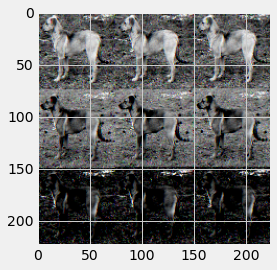

In [83]:
plt.imshow(Img1.reshape(224, 224, 3))

In [78]:
y_pred = model(Img1.reshape(1,3,224,224))

In [80]:
torch.argmax(y_pred,axis=1)

tensor([1])

In [81]:
target_map = {0:'CAT',1:'DOG'}

# conclusion

In [ ]:
# Tranfer learning helps us to get SOTA RESULTS FASTER with less use of resourses 
# As shown above only with 2 epoch we are getting 94 accuracy